In [1]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import array_sensitivity
import importlib
importlib.reload(array_sensitivity)
from matplotlib.patches import Rectangle
import scipy

In [2]:
# Set instrument parameters
antpos_filepath = "20210226W.cfg"
c = 3e8
min_freq_hz = 0.7e9
max_freq_hz = c / 0.21
freq_hz = np.mean([min_freq_hz, max_freq_hz])
tsys_k = 25
aperture_efficiency = 0.62
field_of_view_deg2 = 10.6
antenna_diameter_m = 5
freq_resolution_hz = 162.5e3
int_time_s = 15.0 * 60  # 15 minutes in each survey field
max_bl_m = 1000
bao_scales_k = np.array([.03, .2]) / 0.71

In [3]:
antpos = array_sensitivity.get_antpos(antpos_filepath)

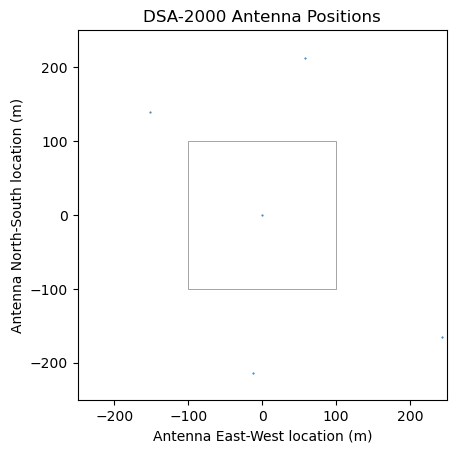

In [4]:
fig, ax = plt.subplots()
ax.plot(antpos[:,0], antpos[:,1], marker="o", markersize=.5, linewidth=0)
ax.set_aspect(1)
ax.set_xlabel("Antenna East-West location (m)")
ax.set_ylabel("Antenna North-South location (m)")
ax.set_title("DSA-2000 Antenna Positions")
ax.add_patch(
    Rectangle((-100, -100), 200, 200, edgecolor = 'grey', fill=False, lw=0.5)         
)
ax.set_aspect("equal")
#plt.savefig("plots/antlocs.png", dpi=600)
plt.xlim([-250, 250])
plt.ylim([-250, 250])
plt.show()

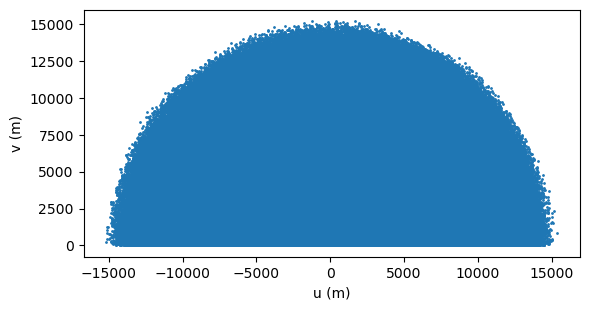

In [5]:
# Get baselines
baselines_m = array_sensitivity.get_baselines(antpos)
fig, ax = plt.subplots()
ax.scatter(baselines_m[:,0], baselines_m[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("u (m)")
ax.set_ylabel("v (m)")
plt.show()

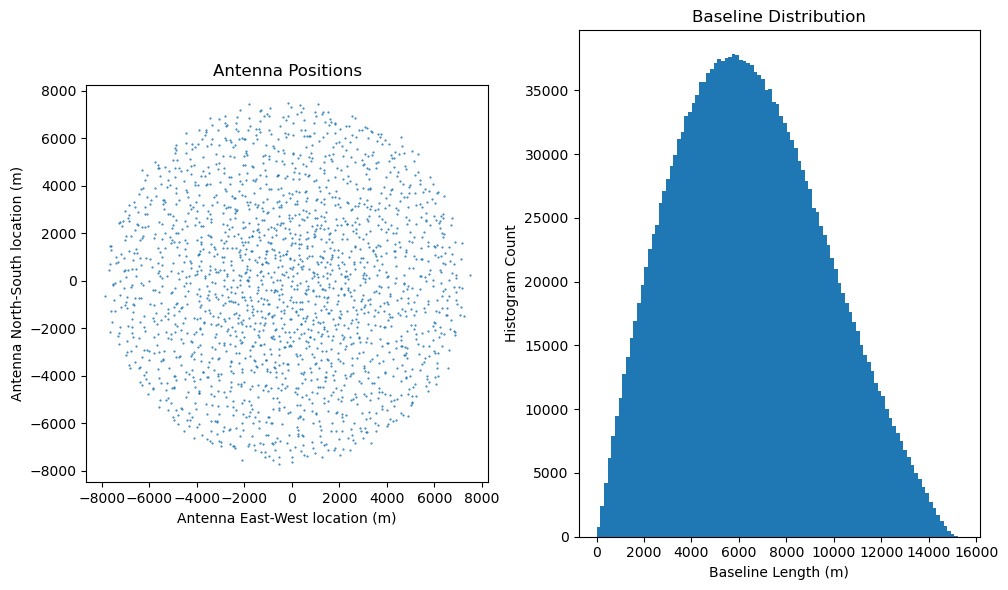

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

ax[0].plot(antpos[:,0], antpos[:,1], marker="o", markersize=.5, linewidth=0)
ax[0].set_aspect(1)
ax[0].set_xlabel("Antenna East-West location (m)")
ax[0].set_ylabel("Antenna North-South location (m)")
ax[0].set_title("Antenna Positions")
ax[0].set_aspect("equal")

ax[1].hist(np.sqrt(np.sum(baselines_m**2., axis=1)), bins=100)
ax[1].set_xlabel("Baseline Length (m)")
ax[1].set_ylabel("Histogram Count")
ax[1].set_title("Baseline Distribution")

plt.tight_layout()
plt.savefig("plots/antlocs.png", dpi=600)
plt.show()

In [7]:
# Define bin edges:
freq_array_hz = np.arange(min_freq_hz, max_freq_hz, freq_resolution_hz)
delay_array_s = np.fft.fftshift(
    np.fft.fftfreq(len(freq_array_hz), d=freq_resolution_hz)
)
kpar_conv_factor = array_sensitivity.get_kpar_conversion_factor(freq_hz)
max_kpar = kpar_conv_factor * np.max(delay_array_s)

kperp_conv_factor = array_sensitivity.get_kperp_conversion_factor(freq_hz)
max_baseline_wl = np.max(np.sqrt(np.sum(baselines_m**2.0, axis=1))) * max_freq_hz / c
max_kperp = kperp_conv_factor * max_baseline_wl
max_k = np.sqrt(max_kpar**2.0 + max_kperp**2.0)

k_bin_size = 0.1
min_k = 0.02
bin_edges = np.arange(min_k, max_k, k_bin_size)
kpar_bin_edges = np.arange(0, max_kpar, k_bin_size)
kperp_bin_edges = np.arange(0, max_kperp, k_bin_size)

# Run in notebook
#max_k = 5
#bin_edges = np.arange(min_k, max_k, k_bin_size)
#kpar_bin_edges = np.copy(bin_edges)
#kperp_bin_edges = np.copy(bin_edges)

In [8]:
# Restore simulation with horizon wedge cut
with open("simulation_outputs/thermal_noise_no_core_wedge_cut_horizon_za_0.0.npy", "rb") as f:
    nsamples_horizon_cut = np.load(f)
    binned_ps_variance_horizon_cut = np.load(f)
    true_bin_edges_horizon_cut = np.load(f)
    true_bin_centers_horizon_cut = np.load(f)
    nsamples_2d_restored = np.load(f)
    binned_ps_variance_2d_restored = np.load(f)
f.close()

In [9]:
# Restore simulation with FoV wedge cut
with open("simulation_outputs/thermal_noise_no_core_wedge_cut_fov_za_0.0.npy", "rb") as f:
    nsamples_fov_cut = np.load(f)
    binned_ps_variance_fov_cut = np.load(f)
    true_bin_edges_fov_cut = np.load(f)
    true_bin_centers_fov_cut = np.load(f)
f.close()

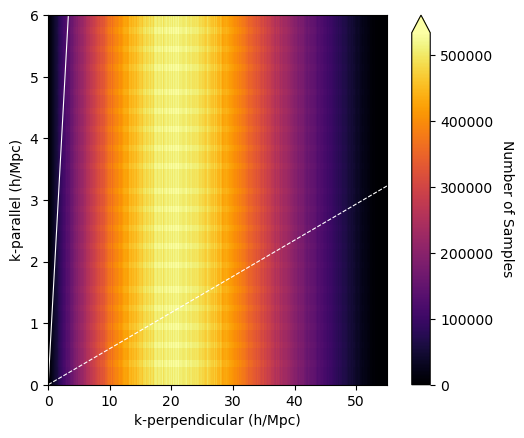

In [10]:
# Make 2D Nsamples plot from restored data

# Get wedge slope
kperp_conv_factor = array_sensitivity.get_kperp_conversion_factor(freq_hz)
kpar_conv_factor = array_sensitivity.get_kpar_conversion_factor(freq_hz)
wedge_slope = kpar_conv_factor / (kperp_conv_factor * freq_hz)

field_of_view_radius = np.sqrt(field_of_view_deg2 / np.pi)
fov_wedge_slope = wedge_slope * np.sin(np.radians(field_of_view_radius))

fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    nsamples_2d_restored.T,
    origin="lower",
    interpolation="none",
    extent=[
        np.min(kperp_bin_edges),
        np.max(kperp_bin_edges),
        np.min(kpar_bin_edges),
        np.max(kpar_bin_edges)
    ],
    vmin=0,
    vmax=np.max(nsamples_2d_restored),
    cmap=use_cmap,
    #norm="log",
    aspect=10.,
)
ax.set_xlabel("k-perpendicular (h/Mpc)")
ax.set_ylabel("k-parallel (h/Mpc)")
ax.set_xlim([0, 55])
ax.set_ylim([0, np.max(kpar_bin_edges)])
plt.plot([0, 55], [0, wedge_slope*55], c="white", linewidth=.8)
plt.plot([0, 55], [0, fov_wedge_slope*55], "--", c="white", linewidth=.8)
#ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("Number of Samples", rotation=270, labelpad=15)
plt.savefig("plots/2d_nsampes.png", dpi=600)
plt.show()

In [11]:
# Run horizon cut simulation in notebook
"""
(
    nsamples_horizon_cut,
    binned_ps_variance_horizon_cut,
    true_bin_edges_horizon_cut,
    true_bin_centers_horizon_cut,
    nsamples_2d_horizon_cut,
    binned_ps_variance_2d_horizon_cut,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=max_bl_m,
    k_bin_edges_1d=bin_edges,
    kpar_bin_edges=kpar_bin_edges,
    kperp_bin_edges=kperp_bin_edges,
    wedge_extent_deg=90.0,
    zenith_angle=0.0,
)
"""

'\n(\n    nsamples_horizon_cut,\n    binned_ps_variance_horizon_cut,\n    true_bin_edges_horizon_cut,\n    true_bin_centers_horizon_cut,\n    nsamples_2d_horizon_cut,\n    binned_ps_variance_2d_horizon_cut,\n) = array_sensitivity.delay_ps_sensitivity_analysis(\n    antpos_filepath=antpos_filepath,\n    min_freq_hz=min_freq_hz,\n    max_freq_hz=max_freq_hz,\n    tsys_k=tsys_k,\n    aperture_efficiency=aperture_efficiency,\n    antenna_diameter_m=antenna_diameter_m,\n    freq_resolution_hz=freq_resolution_hz,\n    int_time_s=int_time_s,\n    max_bl_m=max_bl_m,\n    k_bin_edges_1d=bin_edges,\n    kpar_bin_edges=kpar_bin_edges,\n    kperp_bin_edges=kperp_bin_edges,\n    wedge_extent_deg=90.0,\n    zenith_angle=0.0,\n)\n'

In [12]:
# Run FoV cut simulation in notebook
"""
(
    nsamples_fov_cut,
    binned_ps_variance_fov_cut,
    true_bin_edges_fov_cut,
    true_bin_centers_fov_cut,
    nsamples_2d_fov_cut,
    binned_ps_variance_2d_fov_cut,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=max_bl_m,
    k_bin_edges_1d=bin_edges,
    kpar_bin_edges=kpar_bin_edges,
    kperp_bin_edges=kperp_bin_edges,
    wedge_extent_deg=1.84,
    zenith_angle=0.0,
)
"""

'\n(\n    nsamples_fov_cut,\n    binned_ps_variance_fov_cut,\n    true_bin_edges_fov_cut,\n    true_bin_centers_fov_cut,\n    nsamples_2d_fov_cut,\n    binned_ps_variance_2d_fov_cut,\n) = array_sensitivity.delay_ps_sensitivity_analysis(\n    antpos_filepath=antpos_filepath,\n    min_freq_hz=min_freq_hz,\n    max_freq_hz=max_freq_hz,\n    tsys_k=tsys_k,\n    aperture_efficiency=aperture_efficiency,\n    antenna_diameter_m=antenna_diameter_m,\n    freq_resolution_hz=freq_resolution_hz,\n    int_time_s=int_time_s,\n    max_bl_m=max_bl_m,\n    k_bin_edges_1d=bin_edges,\n    kpar_bin_edges=kpar_bin_edges,\n    kperp_bin_edges=kperp_bin_edges,\n    wedge_extent_deg=1.84,\n    zenith_angle=0.0,\n)\n'

In [13]:
# Load CAMB power spectrum data
f = open("camb_49591724_matterpower_z0.5.dat", "r")
file_data = f.readlines()
f.close()
model_k_axis = []
ps_model_unnorm = []
for line in file_data:
    model_k_axis.append(float(line.split()[0]))
    ps_model_unnorm.append(float(line.split()[1]))
ps_model = array_sensitivity.matter_ps_to_21cm_ps_conversion(
    np.array(model_k_axis),
    np.array(ps_model_unnorm),
    0.5
)


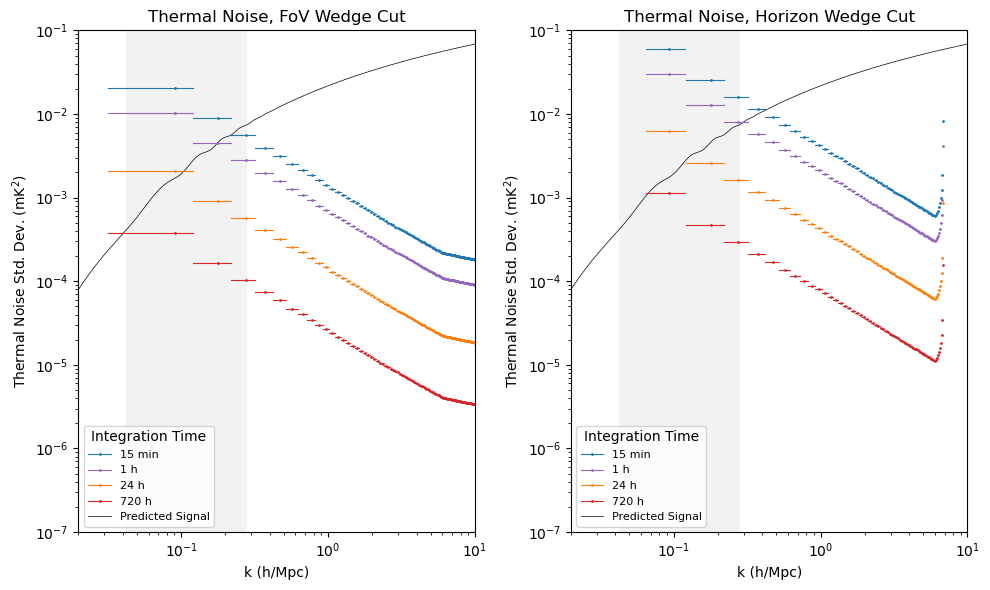

In [14]:
plot_integration_times_h = [.25, 1, 24, 720]
colors = ['tab:blue','tab:purple','tab:orange','tab:red']
legend_labels = [
    "15 min",
    "1 h",
    "24 h",
    "720 h",
    "Predicted Signal",
]
xrange = [2e-2, 10]
yrange = [1e-7, 1e-1]

legend_lines = [Line2D([0], [0], linewidth=0.8, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

for wedge_cut_ind in range(2):
    if wedge_cut_ind == 0:
        use_binned_ps_variance = binned_ps_variance_fov_cut
        use_true_bin_centers = true_bin_centers_fov_cut
        use_true_bin_edges = true_bin_edges_fov_cut
        title = "Thermal Noise, FoV Wedge Cut"
    else:
        use_binned_ps_variance = binned_ps_variance_horizon_cut
        use_true_bin_centers = true_bin_centers_horizon_cut
        use_true_bin_edges = true_bin_edges_horizon_cut
        title = "Thermal Noise, Horizon Wedge Cut"
        
    # Plot theory line
    ax[wedge_cut_ind].plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

    # Plot BAO scales
    ax[wedge_cut_ind].fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

    for int_time_ind, int_time in enumerate(plot_integration_times_h):
        plot_vals = np.sqrt(use_binned_ps_variance * .25 / int_time)
        ax[wedge_cut_ind].plot(
            use_true_bin_centers,
            plot_vals,
            marker="o", markersize=1, linewidth=0,
            color=colors[int_time_ind],
        )
        for bin_ind in range(len(plot_vals)):  
            ax[wedge_cut_ind].plot(
                use_true_bin_edges[bin_ind, :],
                [plot_vals[bin_ind], plot_vals[bin_ind]],
                marker="none",
                linewidth=0.8,
                color=colors[int_time_ind],
            )
    ax[wedge_cut_ind].set_yscale("log")
    ax[wedge_cut_ind].set_xscale("log")
    ax[wedge_cut_ind].set_xlim(xrange)
    ax[wedge_cut_ind].set_ylim(yrange)
    ax[wedge_cut_ind].set_xlabel("k (h/Mpc)")
    ax[wedge_cut_ind].set_ylabel("Thermal Noise Std. Dev. (mK$^2$)")
    ax[wedge_cut_ind].legend(legend_lines, legend_labels, prop={'size': 8}, title="Integration Time")
    ax[wedge_cut_ind].set_title(title)

plt.tight_layout()
plt.savefig("plots/thermal_noise_stddev.png")
plt.show()

In [15]:
binned_ps_sample_variance_horizon_cut = array_sensitivity.get_sample_variance(
    ps_model,  # Units mK^2
    model_k_axis,  # Units h/Mpc
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges,
    wedge_extent_deg=90.0,
)
binned_ps_sample_variance_fov_cut = array_sensitivity.get_sample_variance(
    ps_model,  # Units mK^2
    model_k_axis,  # Units h/Mpc
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges,
    wedge_extent_deg=1.84,
)

Kpar correlation length: 0.0026804503556863445
Kperp correlation length: 0.024563210483693594
Correlation volume: 1.617253231526501e-06
Kpar correlation length: 0.0026804503556863445
Kperp correlation length: 0.024563210483693594
Correlation volume: 1.617253231526501e-06


/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_9332/2263846999.py:33: RuntimeWarning: invalid value encountered in sqrt
  plot_vals = np.sqrt(use_binned_ps_sample_variance * field_of_view_deg2 / use_fov)


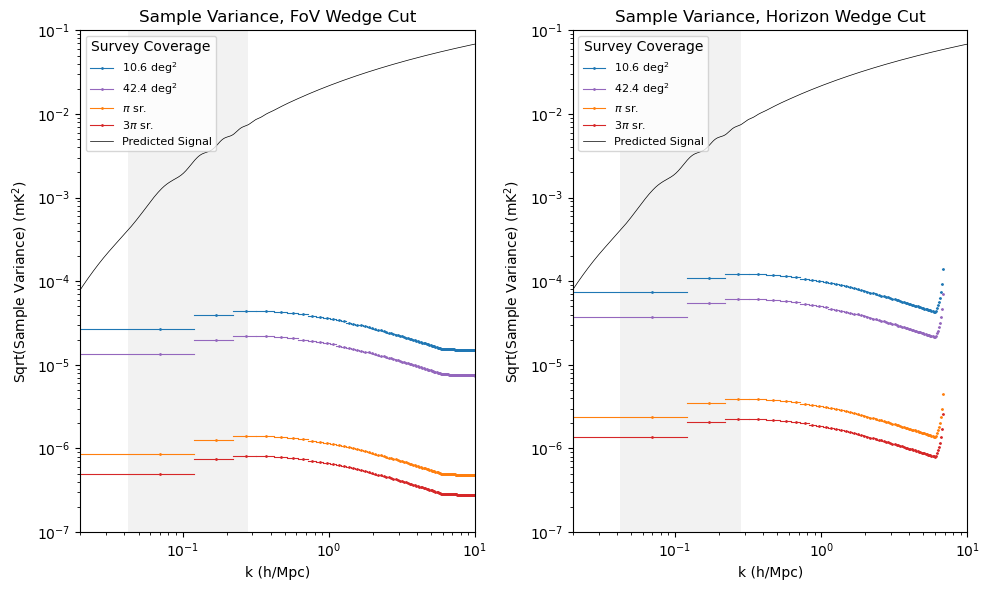

In [93]:
plot_fov_deg = [10.6, 42.4, np.pi*(180/np.pi)**2., 3*np.pi*(180/np.pi)**2.]
colors = ['tab:blue', 'tab:purple', 'tab:orange', 'tab:red']
legend_labels = [
    "10.6 deg$^2$",
    "42.4 deg$^2$",
    "$\pi$ sr.",
    "3$\pi$ sr.",
    "Predicted Signal",
]
xrange = [2e-2, 10]
yrange = [1e-7, 1e-1]

legend_lines = [Line2D([0], [0], linewidth=0.8, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

for wedge_cut_ind in range(2):
    if wedge_cut_ind == 0:
        use_binned_ps_sample_variance = binned_ps_sample_variance_fov_cut
        title = "Sample Variance, FoV Wedge Cut"
    else:
        use_binned_ps_sample_variance = binned_ps_sample_variance_horizon_cut
        title = "Sample Variance, Horizon Wedge Cut"
        
    # Plot theory line
    ax[wedge_cut_ind].plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

    # Plot BAO scales
    ax[wedge_cut_ind].fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

    for fov_ind, use_fov in enumerate(plot_fov_deg):
        plot_vals = np.sqrt(use_binned_ps_sample_variance * field_of_view_deg2 / use_fov)
        ax[wedge_cut_ind].plot(
            (bin_edges[:-1] + bin_edges[1:]) / 2,
            plot_vals,
            marker="o", markersize=1, linewidth=0,
            color=colors[fov_ind],
        )
        for bin_ind in range(len(plot_vals)):  
            ax[wedge_cut_ind].plot(
                [bin_edges[bin_ind], bin_edges[bin_ind + 1]],
                [plot_vals[bin_ind], plot_vals[bin_ind]],
                marker="none",
                linewidth=0.8,
                color=colors[fov_ind],
            )
    ax[wedge_cut_ind].set_yscale("log")
    ax[wedge_cut_ind].set_xscale("log")
    ax[wedge_cut_ind].set_xlim(xrange)
    ax[wedge_cut_ind].set_ylim(yrange)
    ax[wedge_cut_ind].set_xlabel("k (h/Mpc)")
    ax[wedge_cut_ind].set_ylabel("Sqrt(Sample Variance) (mK$^2$)")
    ax[wedge_cut_ind].legend(legend_lines, legend_labels, prop={'size': 8}, title="Survey Coverage")
    ax[wedge_cut_ind].set_title(title)

plt.tight_layout()
plt.savefig("plots/sample_stddev.png")
plt.show()

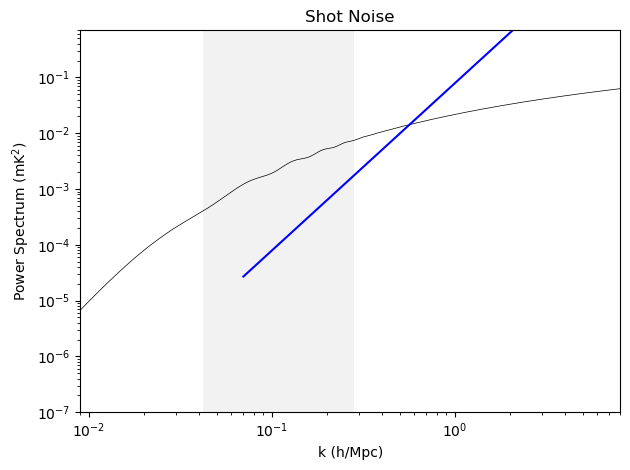

In [17]:
# Get shot noise
shot_noise = array_sensitivity.get_shot_noise(
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    k_bin_edges=bin_edges,
)

xrange = [.9e-2, 8]
yrange = [1e-7, 7e-1]

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, np.sqrt(shot_noise), color="blue")
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.title("Shot Noise")
plt.tight_layout()
plt.show()

In [18]:
combined_variance_fov_cut = (
    (binned_ps_variance_fov_cut * .25 / 720) 
    + (binned_ps_sample_variance_fov_cut * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)
combined_variance_horizon_cut = (
    (binned_ps_variance_horizon_cut * .25 / 720) 
    + (binned_ps_sample_variance_horizon_cut * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)
combined_variance_fov_cut_15_min = binned_ps_variance_fov_cut + binned_ps_sample_variance_fov_cut
combined_variance_horizon_cut_15_min = binned_ps_variance_horizon_cut + binned_ps_sample_variance_horizon_cut

In [19]:
ps_model_interp = np.interp(true_bin_centers_fov_cut, model_k_axis, ps_model)

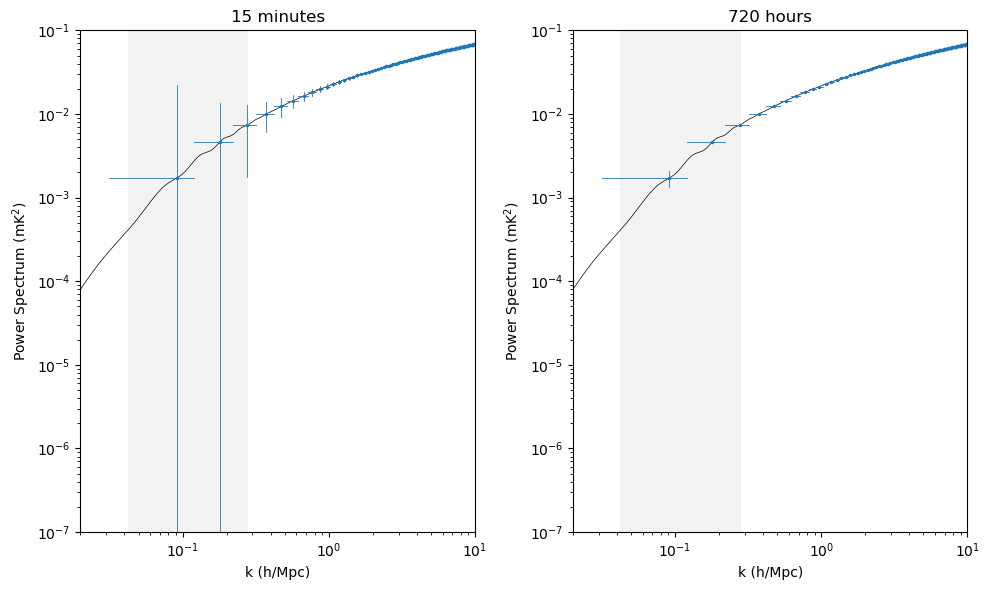

In [50]:
xrange = [2e-2, 10]
yrange = [1e-7, 1e-1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

for int_time_ind in range(2):
    if int_time_ind == 0:
        var_use = combined_variance_fov_cut_15_min
        title = "15 minutes"
    else:
        var_use = combined_variance_fov_cut
        title = "720 hours"

    # Plot theory line
    ax[int_time_ind].plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

    # Plot BAO scales
    ax[int_time_ind].fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

    ax[int_time_ind].plot(true_bin_centers_fov_cut, ps_model_interp, marker="o", color="tab:blue", linewidth=0, markersize=1.5)
    for ind in range(len(ps_model_interp)):
        xvals = [true_bin_centers_fov_cut[ind], true_bin_centers_fov_cut[ind]]
        yvals = [
            ps_model_interp[ind] - np.sqrt(var_use[ind]),
            ps_model_interp[ind] + np.sqrt(var_use[ind])
        ]
        ax[int_time_ind].plot(
            xvals,
            yvals,
            color="tab:blue",
            linewidth=0.6,
            marker="none"
        )
        ax[int_time_ind].plot(
            true_bin_edges_fov_cut[ind, :],
            [ps_model_interp[ind], ps_model_interp[ind]],
            marker="none",
            linewidth=0.6,
            color="tab:blue",
        )

    ax[int_time_ind].set_yscale("log")
    ax[int_time_ind].set_xscale("log")
    ax[int_time_ind].set_xlim(xrange)
    ax[int_time_ind].set_ylim(yrange)
    ax[int_time_ind].set_xlabel("k (h/Mpc)")
    ax[int_time_ind].set_ylabel("Power Spectrum (mK$^2$)")
    ax[int_time_ind].set_title(title)
plt.tight_layout()
plt.savefig("plots/error_bars.png")
plt.show()

In [57]:
detected_inds = np.where(ps_model_interp > 5*np.sqrt(combined_variance_fov_cut_15_min))
print(f"Min mode: {np.min(true_bin_edges_fov_cut[detected_inds, 0])}")
print(f"Max mode: {np.max(true_bin_edges_fov_cut[detected_inds, 1])}")
#print(ps_model_interp - 5*np.sqrt(combined_variance_fov_cut))

Min mode: 0.5200021096456453
Max mode: 54.91996037630726


In [58]:
detected_inds = np.where(ps_model_interp > 5*np.sqrt(combined_variance_fov_cut))
print(f"Min mode: {np.min(true_bin_edges_fov_cut[detected_inds, 0])}")
print(f"Max mode: {np.max(true_bin_edges_fov_cut[detected_inds, 1])}")

Min mode: 0.12001680296196421
Max mode: 55.084276911932804


# BAO Analysis

In [22]:
fit_min_val = 1e-2
fit_max_val = .5
model_k_axis_bao_scales = [k for k in model_k_axis if (k>=fit_min_val) and (k<=fit_max_val)]
ps_model_bao_scales = [ps_model[ind] for ind in range(len(model_k_axis)) if (model_k_axis[ind]>=fit_min_val) and (model_k_axis[ind]<=fit_max_val)]

polyfit = np.polyfit(model_k_axis_bao_scales, ps_model_bao_scales, 4)
ps_model_fit_values = polyfit[-1]
for polyfit_ind in range(len(polyfit)-1):
    ps_model_fit_values += polyfit[polyfit_ind] * np.array(model_k_axis)**(len(polyfit)-1-polyfit_ind)

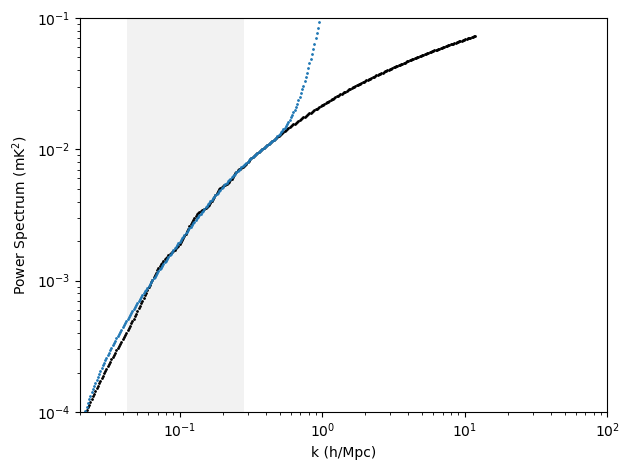

In [23]:
xrange = [2e-2, 100]
yrange = [1e-4, 1e-1]

# Plot theory line
plt.plot(model_k_axis, ps_model, "o", color="black", linewidth=0, markersize=1)
plt.plot(model_k_axis, ps_model_fit_values,"o", markersize=1)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.tight_layout()
plt.show()

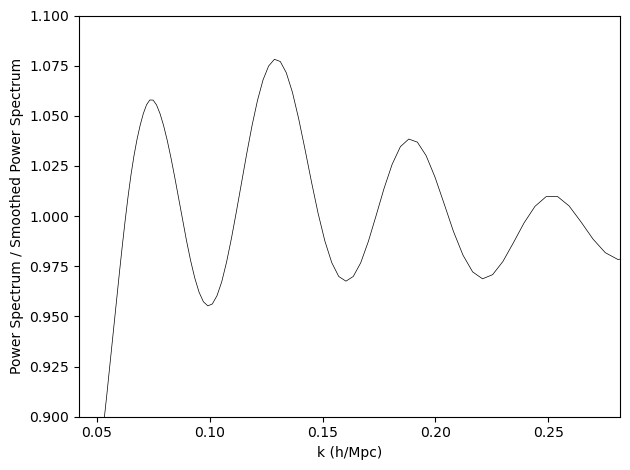

In [24]:
xrange = bao_scales_k
yrange = [.9,1.1]

# Plot theory line
plt.plot(model_k_axis, ps_model/ps_model_fit_values, "-", color="black", linewidth=0.5, markersize=0)
#plt.plot(bin_edges_bao, [1]*len(bin_edges_bao), "o", color="black", linewidth=0, markersize=1)

# Plot BAO scales
#plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

#plt.yscale("log")
#plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum / Smoothed Power Spectrum")
plt.tight_layout()
plt.show()

In [25]:
# Find peaks
model_k_axis = np.array(model_k_axis)
ps_ratio = ps_model/ps_model_fit_values
use_inds = np.where((model_k_axis > 0.05) & (model_k_axis < 0.1))
print(model_k_axis[list(ps_ratio).index(np.max(ps_ratio[use_inds]))])
use_inds = np.where((model_k_axis > 0.1) & (model_k_axis < 0.15))
print(model_k_axis[list(ps_ratio).index(np.max(ps_ratio[use_inds]))])
use_inds = np.where((model_k_axis > 0.15) & (model_k_axis < 0.23))
print(model_k_axis[list(ps_ratio).index(np.max(ps_ratio[use_inds]))])
use_inds = np.where((model_k_axis > 0.23) & (model_k_axis < 0.27))
print(model_k_axis[list(ps_ratio).index(np.max(ps_ratio[use_inds]))])

0.07351
0.12869
0.18818
0.25402


In [26]:
print(0.25402-0.18818)
print(0.18818-0.12869)
print(0.12869-0.07351)
print(np.mean([0.25402-0.18818,0.18818-0.12869,0.12869-0.07351])/2)

0.06584000000000004
0.05948999999999999
0.05517999999999999
0.030085


In [27]:
k_bin_size_bao = 0.03
min_k_bao = 0.12869 - 2.5*k_bin_size_bao
max_k_bao = .35
bin_edges_bao = np.arange(min_k_bao, max_k_bao, k_bin_size_bao)
print(bin_edges_bao)

[0.05369 0.08369 0.11369 0.14369 0.17369 0.20369 0.23369 0.26369 0.29369
 0.32369]


In [79]:
(
    null,
    binned_ps_variance_bao,
    true_bin_edges_bao,
    true_bin_centers_bao,
    null,
    null,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=1000,
    k_bin_edges_1d=bin_edges_bao,
    kpar_bin_edges=bin_edges_bao,
    kperp_bin_edges=bin_edges_bao,
    wedge_extent_deg=1.84,
    zenith_angle=0.0,
)
(
    null,
    binned_ps_variance_bao_offaxis,
    true_bin_edges_bao_offaxis,
    true_bin_centers_bao_offaxis,
    null,
    null,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=1000,
    k_bin_edges_1d=bin_edges_bao,
    kpar_bin_edges=bin_edges_bao,
    kperp_bin_edges=bin_edges_bao,
    wedge_extent_deg=1.84,
    zenith_angle=60.0,
)
(
    null,
    binned_ps_variance_bao_core,
    true_bin_edges_bao_core,
    true_bin_centers_bao_core,
    null,
    null,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath="20210226W_core.cfg",
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=1000,
    k_bin_edges_1d=bin_edges_bao,
    kpar_bin_edges=bin_edges_bao,
    kperp_bin_edges=bin_edges_bao,
    wedge_extent_deg=1.84,
    zenith_angle=0.0,
)
binned_ps_sample_variance_bao = array_sensitivity.get_sample_variance(
    ps_model,  # Units mK^2
    model_k_axis,  # Units h/Mpc
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges_bao,
    wedge_extent_deg=1.84,
)
combined_variance_bao = (
    (binned_ps_variance_bao * .25 / 720) 
    + (binned_ps_sample_variance_bao * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)
combined_variance_bao_offaxis = (
    (binned_ps_variance_bao_offaxis * .25 / 720) 
    + (binned_ps_sample_variance_bao * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)
combined_variance_bao_core = (
    (binned_ps_variance_bao_core * .25 / 720) 
    + (binned_ps_sample_variance_bao * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)

Kpar correlation length: 0.0026804503556863445
Kperp correlation length: 0.024563210483693594
Correlation volume: 1.617253231526501e-06


In [80]:
ps_ratio_interp = np.interp(true_bin_centers_bao, model_k_axis, ps_ratio)
ps_model_fit_values_interp = np.interp(true_bin_centers_bao, model_k_axis, ps_model_fit_values)

combined_variance_bao_ratio = combined_variance_bao / ps_model_fit_values_interp**2.
combined_variance_bao_ratio_offaxis = combined_variance_bao_offaxis / ps_model_fit_values_interp**2.
combined_variance_bao_ratio_core = combined_variance_bao_core / ps_model_fit_values_interp**2.

In [69]:
print(bao_scales_k)

[0.04225352 0.28169014]


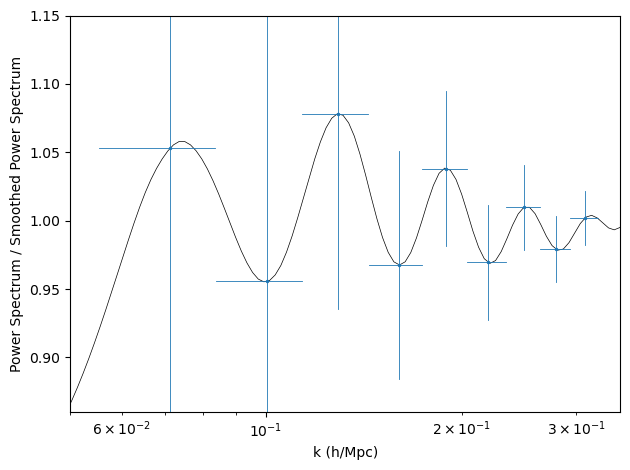

In [83]:
xrange = [0.05,0.35]
yrange = [.86,1.15]

# Plot theory line
plt.plot(model_k_axis, ps_model/ps_model_fit_values, "-", color="black", linewidth=0.5, markersize=0)

plt.plot(true_bin_centers_bao, ps_ratio_interp, marker="o", color="tab:blue", linewidth=0, markersize=1.5)
for ind in range(len(ps_ratio_interp)):
    xvals = [true_bin_centers_bao[ind], true_bin_centers_bao[ind]]
    yvals = [
        ps_ratio_interp[ind] - np.sqrt(combined_variance_bao_ratio[ind]),
        ps_ratio_interp[ind] + np.sqrt(combined_variance_bao_ratio[ind])
    ]
    plt.plot(
        xvals,
        yvals,
        color="tab:blue",
        linewidth=0.6,
        marker="none"
    )
    plt.plot(
        true_bin_edges_bao[ind, :],
        [ps_ratio_interp[ind], ps_ratio_interp[ind]],
        marker="none",
        linewidth=0.6,
        color="tab:blue",
    )
    

# Plot BAO scales
#plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

#plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum / Smoothed Power Spectrum")
plt.tight_layout()
plt.savefig("plots/bao_error_bars.png")
plt.show()

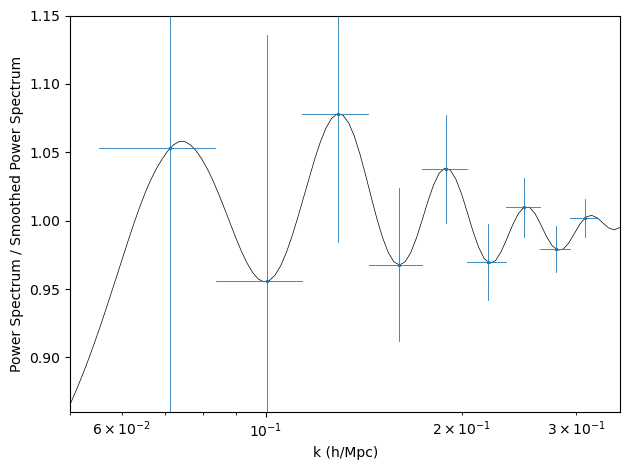

In [82]:
xrange = [0.05,0.35]
yrange = [.86,1.15]

# Plot theory line
plt.plot(model_k_axis, ps_model/ps_model_fit_values, "-", color="black", linewidth=0.5, markersize=0)

plt.plot(true_bin_centers_bao, ps_ratio_interp, marker="o", color="tab:blue", linewidth=0, markersize=1.5)
for ind in range(len(ps_ratio_interp)):
    xvals = [true_bin_centers_bao[ind], true_bin_centers_bao[ind]]
    yvals = [
        ps_ratio_interp[ind] - np.sqrt(combined_variance_bao_ratio_offaxis[ind]),
        ps_ratio_interp[ind] + np.sqrt(combined_variance_bao_ratio_offaxis[ind])
    ]
    plt.plot(
        xvals,
        yvals,
        color="tab:blue",
        linewidth=0.6,
        marker="none"
    )
    plt.plot(
        true_bin_edges_bao[ind, :],
        [ps_ratio_interp[ind], ps_ratio_interp[ind]],
        marker="none",
        linewidth=0.6,
        color="tab:blue",
    )
    

# Plot BAO scales
#plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

#plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum / Smoothed Power Spectrum")
plt.tight_layout()
plt.savefig("plots/bao_error_bars_offaxis.png")
plt.show()

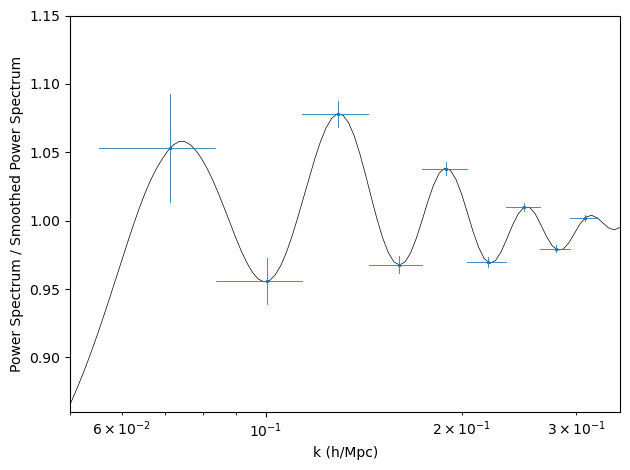

In [84]:
xrange = [0.05,0.35]
yrange = [.86,1.15]

# Plot theory line
plt.plot(model_k_axis, ps_model/ps_model_fit_values, "-", color="black", linewidth=0.5, markersize=0)

plt.plot(true_bin_centers_bao, ps_ratio_interp, marker="o", color="tab:blue", linewidth=0, markersize=1.5)
for ind in range(len(ps_ratio_interp)):
    xvals = [true_bin_centers_bao[ind], true_bin_centers_bao[ind]]
    yvals = [
        ps_ratio_interp[ind] - np.sqrt(combined_variance_bao_ratio_core[ind]),
        ps_ratio_interp[ind] + np.sqrt(combined_variance_bao_ratio_core[ind])
    ]
    plt.plot(
        xvals,
        yvals,
        color="tab:blue",
        linewidth=0.6,
        marker="none"
    )
    plt.plot(
        true_bin_edges_bao[ind, :],
        [ps_ratio_interp[ind], ps_ratio_interp[ind]],
        marker="none",
        linewidth=0.6,
        color="tab:blue",
    )
    

# Plot BAO scales
#plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

#plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum / Smoothed Power Spectrum")
plt.tight_layout()
plt.savefig("plots/bao_error_bars_core.png")
plt.show()

In [89]:
print([ps_ratio_interp[0],ps_ratio_interp[2],ps_ratio_interp[4]])
print([ps_ratio_interp[1],ps_ratio_interp[3],ps_ratio_interp[5]])
print(np.sqrt(combined_variance_bao_ratio_core[0:6]))

[1.0530108835298397, 1.078080348903745, 1.0379603923150817]
[0.9558258520464863, 0.9678294999064591, 0.9696283722555493]
[0.03959123 0.01712961 0.00976713 0.00627863 0.00455957 0.00355221]


In [90]:
print(1.0530108835298397-0.9558258520464863)
print(5*(np.sqrt(combined_variance_bao_ratio_core[0])+np.sqrt(combined_variance_bao_ratio_core[1])))

0.09718503148335345
0.28360419036135304


In [91]:
print(1.078080348903745-0.9678294999064591)
print(5*(np.sqrt(combined_variance_bao_ratio_core[2])+np.sqrt(combined_variance_bao_ratio_core[3])))

0.11025084899728588
0.08022878378161293


In [92]:
print(1.0379603923150817-0.9696283722555493)
print(5*(np.sqrt(combined_variance_bao_ratio_core[4])+np.sqrt(combined_variance_bao_ratio_core[5])))

0.06833202005953243
0.04055887080258316


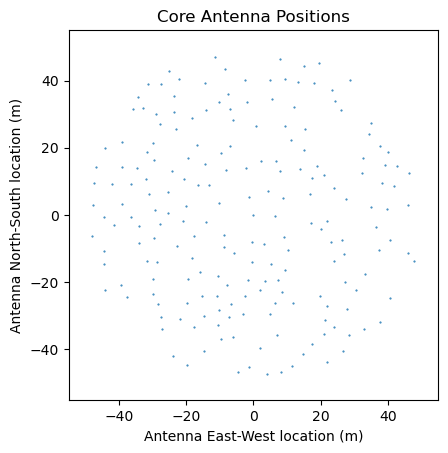

In [110]:
antlocs_core = array_sensitivity.get_antpos("20210226W_core.cfg")
fig, ax = plt.subplots()
ax.plot(antlocs_core[:,0], antlocs_core[:,1], marker="o", markersize=.5, linewidth=0)
ax.set_aspect(1)
ax.set_xlabel("Antenna East-West location (m)")
ax.set_ylabel("Antenna North-South location (m)")
ax.set_title("Core Antenna Positions")
#ax.add_patch(
#    Rectangle((-100, -100), 200, 200, edgecolor = 'grey', fill=False, lw=0.5)         
#)
ax.set_aspect("equal")
plt.xlim([-55, 55])
plt.ylim([-55, 55])
plt.savefig("plots/antlocs_core.png", dpi=600)
plt.show()

# Off-Zenith Analysis
Look at a zenith angle of 60 degrees

In [31]:
(
    nsamples_offzenith,
    binned_ps_variance_offzenith,
    true_bin_edges_offzenith,
    true_bin_centers_offzenith,
    nsamples_2d_offzenith,
    binned_ps_variance_2d_offzenith,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=max_bl_m,
    k_bin_edges_1d=bin_edges,
    kpar_bin_edges=kpar_bin_edges,
    kperp_bin_edges=kperp_bin_edges,
    zenith_angle=60.
)

/Users/ruby/Astro/PSsensitivity/array_sensitivity.py:349: RuntimeWarning: divide by zero encountered in true_divide
  binned_ps_variance_2d = ps_variance / nsamples_2d


KeyboardInterrupt: 

In [ ]:
combined_variance_single_field_offzenith = binned_ps_variance_offzenith + binned_ps_sample_variance
combined_variance_all_sky_offzenith = (
    (binned_ps_variance_offzenith * .25 / 720) 
    + (binned_ps_sample_variance * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)

In [ ]:
colors = ['tab:blue', 'tab:red']
legend_labels = [
    "15 min, 10.6 deg$^2$",
    "720 h, 3$\pi$ sr.",
    "Predicted Signal",
]
xrange = [1e-2, 8]
yrange = [2e-6, 7e-1]

legend_lines = [Line2D([0], [0], linewidth=1, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for data_ind, plot_vals in enumerate(np.sqrt([combined_variance_single_field_offzenith, combined_variance_all_sky_offzenith])):
    plt.plot(
        true_bin_centers_offzenith,
        plot_vals,
        marker="o", markersize=1, linewidth=0,
        color=colors[data_ind],
    )
    for bin_ind in range(len(plot_vals)):  
        plt.plot(
            true_bin_edges_offzenith[bin_ind, :],
            [plot_vals[bin_ind], plot_vals[bin_ind]],
            marker="none",
            linewidth=1,
            color=colors[data_ind],
        )
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.legend(legend_lines, legend_labels, prop={'size': 8}, title="Observation Parameters")
plt.title("Combined Noise Std. Dev., Off-Axis Observation")
plt.tight_layout()
plt.savefig("plots/combined_noise_stddev_offzenith.png")
plt.show()

In [ ]:
brightness_temp = array_sensitivity.get_brightness_temp(1)

In [ ]:
print(brightness_temp**2. * .1**3. / 2 / np.pi**2. /.01)

In [ ]:
print(brightness_temp)